In [47]:
# Import packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import statistics as sts
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import datetime as dt
import sklearn as sk
from sklearn import mixture
from sklearn import naive_bayes
from sklearn import model_selection
from sklearn import neighbors
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import ensemble
from sklearn import linear_model
from sklearn import metrics
from xgboost import XGBClassifier
import networkx as nx

In [4]:
# Import .csv file as a dataframe
data = pd.read_csv('human-resources-data-set/core_dataset.csv')

# Count number of observations and features
obs, nvar = data.shape
print('Number of Individuals (all): {x:}'.format(x=obs))
print('Number of variables: {x:}'.format(x=nvar))

# View table
data=data.drop(301,axis=0)
data.tail()

Number of Individuals (all): 302
Number of variables: 21


,Employee Name,Employee Number,State,Zip,DOB,Age,Sex,MaritalDesc,CitizenDesc,Hispanic/Latino,...,Date of Hire,Date of Termination,Reason For Term,Employment Status,Department,Position,Pay Rate,Manager Name,Employee Source,Performance Score
296,"Patronick, Luke",1.112031e+09,MA,1844.0,2/20/1979,38.0,Male,Single,US Citizen,No,...,11/7/2011,9/7/2015,Another position,Voluntarily Terminated,Software Engineering,Software Engineer,52.25,Alex Sweetwater,Diversity Job Fair,Exceeds
297,"Saada, Adell",1.012023e+09,MA,2132.0,7/24/1986,31.0,Female,Married,US Citizen,No,...,11/5/2012,NaN,N/A - still employed,Active,Software Engineering,Software Engineer,49.25,Alex Sweetwater,Pay Per Click - Google,Fully Meets
298,"Szabo, Andrew",1.201031e+09,MA,2140.0,5/6/1983,34.0,Male,Single,US Citizen,No,...,7/7/2014,NaN,N/A - still employed,Active,Software Engineering,Software Engineer,48.00,Alex Sweetwater,MBTA ads,Exceptional
299,"True, Edward",1.102024e+09,MA,2451.0,6/14/1983,34.0,Male,Single,Non-Citizen,No,...,2/18/2013,4/15/2014,medical issues,Voluntarily Terminated,Software Engineering,Software Engineer,45.42,Alex Sweetwater,Diversity Job Fair,Fully Meets
300,"Sweetwater, Alex",1.001645e+09,MA,2184.0,11/22/1966,51.0,Male,Single,US Citizen,No,...,8/15/2011,NaN,N/A - still employed,Active,Software Engineering,Software Engineering Manager,27.00,Jennifer Zamora,Search Engine - Google Bing Yahoo,Fully Meets


Need to clean up the data here, Check # of entries for each column and rewrite/add missing data etc...

In [5]:
#Replace the ugly column headers with something that is easier to work with. 
data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('/','_')

In [6]:
#make all dates the same format.
data.date_of_hire=data.date_of_hire.str.replace('/','.')
data.date_of_termination=data.date_of_termination.str.replace('/','.')
data.dob=data.dob.str.replace('/','.')
data['dob']=pd.to_datetime(data['dob'])
data['date_of_hire']=pd.to_datetime(data['date_of_hire'])
data['date_of_termination']=pd.to_datetime(data['date_of_termination'])
print(data.dtypes)


employee_name                  object
employee_number               float64
state                          object
zip                           float64
dob                    datetime64[ns]
age                           float64
sex                            object
maritaldesc                    object
citizendesc                    object
hispanic_latino                object
racedesc                       object
date_of_hire           datetime64[ns]
date_of_termination    datetime64[ns]
reason_for_term                object
employment_status              object
department                     object
position                       object
pay_rate                      float64
manager_name                   object
employee_source                object
performance_score              object
dtype: object


In [7]:
#Making sure string entries are uniform (caps or not, useless spaces on end)
data.sex=data.sex.str.strip().str.capitalize()
data.maritaldesc=data.maritaldesc.str.strip().str.capitalize()
data.hispanic_latino=data.hispanic_latino.str.strip().str.capitalize()
data.department=data.department.str.strip()

In [8]:
data[data.employee_number.duplicated()]
#Two employees with the same number, this can create problems. Decision: Assign New number to one 

,employee_name,employee_number,state,zip,dob,age,sex,maritaldesc,citizendesc,hispanic_latino,...,date_of_hire,date_of_termination,reason_for_term,employment_status,department,position,pay_rate,manager_name,employee_source,performance_score
153,"Ndzi, Horia",1.204033e+09,MA,2421.0,1983-03-28,34.0,Male,Married,US Citizen,No,...,2013-04-01,2016-05-25,more money,Voluntarily Terminated,Production,Production Technician I,22.0,Amy Dunn,Employee Referral,Fully Meets


Checking for Unique values in columns, this already gives a lot of information:

In [9]:
data.loc[152,'employee_number']+=1

In [10]:
for col in data.columns:
    print(data[col].unique())
    print(data[col].nunique())

['Brown, Mia' 'LaRotonda, William  ' 'Steans, Tyrone  ' 'Howard, Estelle'
 'Singh, Nan ' 'Smith, Leigh Ann' 'LeBlanc, Brandon  R' 'Quinn, Sean'
 'Boutwell, Bonalyn' 'Foster-Baker, Amy' 'King, Janet' 'Zamora, Jennifer'
 'Becker, Renee' 'Goble, Taisha' 'Hernandez, Daniff' 'Horton, Jayne'
 'Johnson, Noelle ' 'Murray, Thomas' 'Pearson, Randall'
 'Petrowsky, Thelma' 'Roby, Lori ' 'Rogers, Ivan' 'Salter, Jason'
 'Simard, Kramer' 'Zhou, Julia' 'Foss, Jason' 'Roup,Simon' 'Ruiz, Ricardo'
 'Monroe, Peter' 'Dougall, Eric' 'Clayton, Rick' 'Galia, Lisa'
 'Lindsay, Leonara ' 'Soto, Julia ' 'Bacong, Alejandro ' 'Cisco, Anthony'
 'Dolan, Linda' 'Gonzalez, Maria' 'Merlos, Carlos' 'Morway, Tanya'
 'Shepard, Anita ' 'Tredinnick, Neville ' 'Turpin, Jumil'
 'Ait Sidi, Karthikeyan   ' 'Carr, Claudia  N' 'Favis, Donald  '
 'Roehrich, Bianca' 'Daniele, Ann  ' 'Lajiri,  Jyoti'
 'Semizoglou, Jeremiah  ' 'South, Joe' 'Warfield, Sarah' 'Bramante, Elisa'
 'Albert, Michael  ' 'Bozzi, Charles' 'Butler, Webster  L' '

In [11]:
#Double Check to make sure there are no dodgy situations
print(data[((data['employment_status'] == 'Voluntarily Terminated')|(data['employment_status'] == 'Terminated for Cause'))& (data.date_of_termination.isnull())])
print(data[((data['employment_status'] == 'Active')|(data['employment_status'] == 'Leave of Absence')|(data['employment_status'] == 'Future Start'))& (data.date_of_termination.notnull())])
print(data[((data['employment_status'] == 'Terminated for Cause'))& (data.reason_for_term=='hours')])
print(data[((data['employment_status'] == 'Voluntarily Terminated'))& (data.reason_for_term=='performance')])
print(data[((data['employment_status'] == 'Voluntarily Terminated'))& (data.reason_for_term=='attendance')])

Empty DataFrame
Columns: [employee_name, employee_number, state, zip, dob, age, sex, maritaldesc, citizendesc, hispanic_latino, racedesc, date_of_hire, date_of_termination, reason_for_term, employment_status, department, position, pay_rate, manager_name, employee_source, performance_score]
Index: []

[0 rows x 21 columns]
     employee_name  employee_number state     zip        dob   age     sex  \
3  Howard, Estelle     1.211051e+09    MA  2170.0 1985-09-16  32.0  Female   

  maritaldesc citizendesc hispanic_latino            ...             \
3     Married  US Citizen              No            ...              

  date_of_hire date_of_termination       reason_for_term employment_status  \
3   2015-02-16          2015-04-15  N/A - still employed            Active   

      department                  position pay_rate        manager_name  \
3  Admin Offices  Administrative Assistant     21.5  Brandon R. LeBlanc   

          employee_source         performance_score  
3  Pay Per Cli

In [12]:
#Removing the termination date for the active employee
data.loc[3,'date_of_termination']=pd.NaT
#Turning voluntary into caused for reasons: performance and attendance
data.loc[[18,172],'reason_for_term']='Terminated for Cause'
#Turning cause into voluntary for reasons: hours
data.loc[45,'reason_for_term']='Voluntarily Terminated'

In [13]:
# Are they empty cells? Look for Just spaces and NaN
for i in range(len(data.columns)-1):
    counter = data.iloc[:,i].isnull().sum()
    for j in range(len(data)-1):
        if (data.iloc[j,i]==' '):
            counter += 1        
    print('Empty cells in {f:}: {n:}'.format(f=data.columns[i], n=counter))

Empty cells in employee_name: 0
Empty cells in employee_number: 0
Empty cells in state: 0
Empty cells in zip: 0
Empty cells in dob: 0
Empty cells in age: 0
Empty cells in sex: 0
Empty cells in maritaldesc: 0
Empty cells in citizendesc: 0
Empty cells in hispanic_latino: 0
Empty cells in racedesc: 0
Empty cells in date_of_hire: 0
Empty cells in date_of_termination: 199
Empty cells in reason_for_term: 0
Empty cells in employment_status: 0
Empty cells in department: 0
Empty cells in position: 0
Empty cells in pay_rate: 0
Empty cells in manager_name: 0
Empty cells in employee_source: 0


Correct, there are no missing cells except in the termination date data. 

Converting the performance into a score so one can compare. 

In [14]:
order=['N/A- too early to review','PIP','Needs Improvement','90-day meets','Fully Meets','Exceeds','Exceptional']
data["performance_score"] = data["performance_score"].astype('category',ordered=True,categories=order).cat.codes

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  


In [15]:
#Save core dataset, but keep working in this notebook as all the datetime will be reverted if re-importing
data.to_csv(r'results/clean_core.csv')

In [16]:
data.age.mean()

38.548172757475086

# 1. Looking for ROI of recruitment activities

In [17]:
#Import recruitment costs for the different channels.
rec=pd.read_csv('human-resources-data-set/recruiting_costs.csv',index_col=0)

In [18]:
#Create new column that is supposed to represent value of an employee. 
pd.to_numeric(data.performance_score)
data['tenure']=data['date_of_termination'].fillna(dt.datetime(2016,7,1))-data['date_of_hire']
data['tenure']=data['tenure'].dt.days
data['return']=data['pay_rate']*data['performance_score'].replace(0,3)*data['tenure']

In [19]:
rec['return_mean']=data[['return','employee_source']].groupby('employee_source').mean()['return']
rec['return_sum']=data[['return','employee_source']].groupby('employee_source').sum()['return']
rec.return_sum=rec.return_sum/(rec.return_sum.max()-rec.return_sum.min())*10000
rec['ROI']=rec['return_sum']/(rec['Total'].replace(0,1))

In [20]:
rec1=rec[rec['Total']!=0]
#Choosing those sources with or without costs--> Can export accordingly

In [21]:
rec[['Total','return_mean','return_sum','ROI']].to_csv(r'results/ROI.csv')

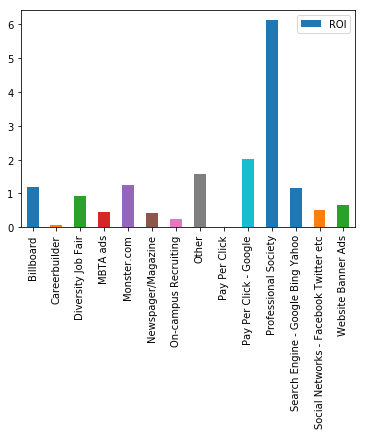

In [22]:
rec1.plot.bar(y='ROI')

# 4. Looking if there is fair compensation for employees

In [23]:
pay=pd.read_csv('human-resources-data-set/salary_grid.csv',index_col=0)
abut=pd.read_csv('human-resources-data-set/production_staff.csv')

In [24]:
data['rel_pay']=data['pay_rate']/data['position'].map(pay.mid_hr)


In [25]:
pay = data.drop(columns=['employee_number','dob','date_of_hire','date_of_termination','reason_for_term','employment_status','department','position','manager_name'])
pay=pay[pay['rel_pay'].notnull()]

In [26]:
pay.groupby('hispanic_latino').mean()

,zip,age,pay_rate,performance_score,tenure,return,rel_pay
hispanic_latino,,,,,,,
No,2497.682464,38.454976,24.226588,3.232227,921.933649,79223.762180,1.048086
Yes,2187.047619,36.952381,25.057143,3.238095,803.714286,69587.145238,1.030527


In [27]:
pay.to_csv(r'results/pay.csv')
#Export and look at results in tableau 

# 2. Classify Employees to try and predict those who will leave soon

In [28]:
classify=data[['age','sex','maritaldesc','citizendesc','racedesc','employment_status','department','position','pay_rate','manager_name','performance_score','tenure','rel_pay']]

In [29]:
order_mar=['Married','Single','Separated','Divorced','Widowed']
classify.loc[:,'maritaldesc'] = classify['maritaldesc'].astype('category',ordered=True,categories=order_mar).cat.codes
pd.to_numeric(classify.maritaldesc)
order_cit=['US Citizen','Eligible NonCitizen','Non-Citizen']
classify.loc[:,'citizendesc'] = classify['citizendesc'].astype('category',ordered=True,categories=order_cit).cat.codes
pd.to_numeric(classify.citizendesc)
order_race=['White','Asian','Black or African American','Two or more races','Hispanic','American Indian or Alaska Native']
classify.loc[:,"racedesc"] = classify["racedesc"].astype('category',ordered=True,categories=order_race).cat.codes
pd.to_numeric(classify.racedesc)
order_sex=['Female','Male']
classify.loc[:,"sex"] = classify["sex"].astype('category',ordered=True,categories=order_sex).cat.codes
pd.to_numeric(classify.sex)
order_dept=['Admin Offices','Executive Office','IT/IS','Production','Sales','Software Engineering']
classify.loc[:,"department"] = classify["department"].astype('category',ordered=True,categories=order_dept).cat.codes
pd.to_numeric(classify.department)

order_pos=['Accountant I','Administrative Assistant','Shared Services Manager',
           'Sr. Accountant','President & CEO','CIO','Database Administrator',
           'IT Director','IT Manager - DB','IT Manager - Infra',
           'IT Manager - Support','IT Support','Network Engineer','Sr. DBA',
           'Sr. Network Engineer','Director of Operations','Production Manager',
           'Production Technician I','Production Technician II','Area Sales Manager',
           'Director of Sales','Sales Manager','Software Engineer',
           'Software Engineering Manager']
classify.loc[:,"position"] = classify["position"].astype('category',ordered=True,categories=order_pos).cat.codes
pd.to_numeric(classify.position)
order_man=['Brandon R. LeBlanc','Janet King','Board of Directors','Simon Roup',
           'Jennifer Zamora','Eric Dougall','Peter Monroe','Michael Albert',
           'Elijiah Gray','Webster Butler','Amy Dunn','Ketsia Liebig',
           'Brannon Miller','David Stanley','Kissy Sullivan','Kelley Spirea',
           'Lynn Daneault','John Smith','Debra Houlihan','Alex Sweetwater']
classify.loc[:,"manager_name"] = classify["manager_name"].astype('category',ordered=True,categories=order_man).cat.codes
pd.to_numeric(classify.manager_name)
order_emp=['Active','Voluntarily Terminated','Terminated for Cause','Leave of Absence','Future Start']
classify.loc[:,"employment_status"] = classify["employment_status"].astype('category',ordered=True,categories=order_emp).cat.codes
pd.to_numeric(classify.employment_status)
classify.loc[:,'employment_status']=classify.employment_status.replace(4,0).replace(3,0)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: specifying 'categori

In [30]:
classes=classify.employment_status
classify=classify.drop(columns=['rel_pay','employment_status'])
classify_proc=preprocessing.scale(classify)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


classify_proc is scaled data, classes is the true value (employment status) 

In [31]:
print(classify_proc)

[[-0.73344096 -0.85433311 -0.88846145 ... -2.01874601  0.41156018
   2.73820265]
 [-0.62143399  1.17050363  1.8875963  ... -2.01874601  0.41156018
  -0.12401854]
 [-0.84544792  1.17050363  0.03689113 ... -2.01874601  0.41156018
  -0.52536321]
 ...
 [-0.50942703  1.17050363  0.03689113 ...  1.83479486  1.71555611
  -0.39862279]
 [-0.50942703  1.17050363  0.03689113 ...  1.83479486  0.41156018
  -0.85730241]
 [ 1.39469138  1.17050363  0.03689113 ... -1.20747425  0.41156018
   1.19619418]]


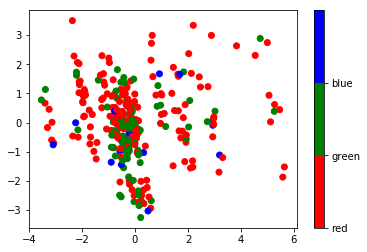

In [32]:
pca=decomposition.PCA(n_components=5)
pca.fit(classify_proc)
pca.n_components_
x=pca.transform(classify_proc)
colors=['red','green','blue']
plt.scatter(x[:,0], x[:,1], c=classes,cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(classes),max(classes)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(colors)

In [33]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, classes, test_size=0.3)

In [34]:
clfr=naive_bayes.GaussianNB()
clfr.fit(x_train,y_train)
y_est=clfr.predict(x_test)
np.count_nonzero(y_est-y_test)/len(y_test)

0.3626373626373626

In [35]:
clfr=neighbors.KNeighborsClassifier()
clfr.fit(x_train,y_train)
y_est=clfr.predict(x_test)
np.count_nonzero(y_est-y_test)/len(y_test)

0.38461538461538464

In [36]:
clfr=ensemble.RandomForestClassifier(n_estimators=50)
clfr.fit(x_train,y_train)
y_est=clfr.predict(x_test)
np.count_nonzero(y_est-y_test)/len(y_test)

0.3516483516483517

In [37]:
clfr=linear_model.LogisticRegression(solver='lbfgs',multi_class='multinomial')
clfr.fit(x_train,y_train)
y_est=clfr.predict(x_test)
np.count_nonzero(y_est-y_test)/len(y_test)

0.3516483516483517

In [100]:
clsf = ensemble.RandomForestClassifier(n_estimators=1000)
grid_search = model_selection.GridSearchCV(clsf, 
                                           {'n_estimators': [50, 100, 500, 1000]},
                                           cv=4,
                                           scoring='accuracy',
                                           iid=False,
                                           return_train_score=False)
grid_search.fit(x, classes)
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.041268,0.001148,0.004054,0.000332,50,{'n_estimators': 50},0.578947,0.500000,0.613333,0.662162,0.588611,0.059089,4
1,0.079331,0.001452,0.007379,0.000521,100,{'n_estimators': 100},0.618421,0.592105,0.680000,0.689189,0.644929,0.040872,3
2,0.416501,0.015621,0.092047,0.098499,500,{'n_estimators': 500},0.631579,0.644737,0.640000,0.689189,0.651376,0.022334,2
3,0.809456,0.007812,0.068704,0.004035,1000,{'n_estimators': 1000},0.631579,0.631579,0.653333,0.702703,0.654798,0.029048,1


In [101]:
clsf = XGBClassifier(n_estimators=1000)
grid_search = model_selection.GridSearchCV(clsf, 
                                           {'n_estimators': [50, 100, 500, 1000]},
                                           cv=4,
                                           scoring='accuracy',
                                           iid=False,
                                           return_train_score=False)
grid_search.fit(x, classes)
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.024959,0.000326,0.000758,0.000025,50,{'n_estimators': 50},0.513158,0.565789,0.613333,0.702703,0.598746,0.069698,2
1,0.048714,0.002133,0.001095,0.000117,100,{'n_estimators': 100},0.592105,0.526316,0.600000,0.702703,0.605281,0.063103,1
2,0.209363,0.002026,0.004080,0.000197,500,{'n_estimators': 500},0.552632,0.539474,0.573333,0.689189,0.588657,0.059284,4
3,0.391464,0.008576,0.007653,0.000460,1000,{'n_estimators': 1000},0.552632,0.578947,0.560000,0.675676,0.591814,0.049360,3


In [104]:
clsf = neighbors.KNeighborsClassifier()
grid_search = model_selection.GridSearchCV(clsf, 
                                           {'n_neighbors': [1, 5, 10, 50, 100], 'weights': ['uniform', 'distance']},
                                           cv=4,
                                           scoring='accuracy',
                                           iid=False,
                                           return_train_score=False)
grid_search.fit(x, classes)
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000805,0.000231,0.001014,0.000199,1,uniform,"{'n_neighbors': 1, 'weights': 'uniform'}",0.407895,0.631579,0.626667,0.608108,0.568562,0.093173,9
1,0.000538,0.000020,0.000903,0.000129,1,distance,"{'n_neighbors': 1, 'weights': 'distance'}",0.407895,0.631579,0.626667,0.608108,0.568562,0.093173,9
2,0.000551,0.000036,0.000913,0.000031,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",0.631579,0.644737,0.613333,0.675676,0.641331,0.022749,5
3,0.000549,0.000011,0.000971,0.000015,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.526316,0.605263,0.640000,0.662162,0.608435,0.051567,8
4,0.000578,0.000031,0.001039,0.000037,10,uniform,"{'n_neighbors': 10, 'weights': 'uniform'}",0.684211,0.671053,0.653333,0.608108,0.654176,0.028766,4
5,0.000512,0.000013,0.001022,0.000008,10,distance,"{'n_neighbors': 10, 'weights': 'distance'}",0.684211,0.605263,0.626667,0.635135,0.637819,0.028912,7
6,0.000621,0.000112,0.001422,0.000030,50,uniform,"{'n_neighbors': 50, 'weights': 'uniform'}",0.657895,0.618421,0.626667,0.662162,0.641286,0.019028,6
7,0.000516,0.000018,0.001512,0.000026,50,distance,"{'n_neighbors': 50, 'weights': 'distance'}",0.657895,0.618421,0.666667,0.675676,0.654665,0.021849,3
8,0.000586,0.000028,0.001928,0.000099,100,uniform,"{'n_neighbors': 100, 'weights': 'uniform'}",0.657895,0.657895,0.666667,0.662162,0.661155,0.003628,1
9,0.000673,0.000130,0.002320,0.000132,100,distance,"{'n_neighbors': 100, 'weights': 'distance'}",0.657895,0.657895,0.666667,0.662162,0.661155,0.003628,1


In [105]:
clsf = linear_model.LogisticRegression(solver='lbfgs', multi_class='multinomial')
grid_search = model_selection.GridSearchCV(clsf, 
                                           {'C': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]},
                                           cv=4,
                                           scoring='accuracy',
                                           iid=False,
                                           return_train_score=False)
grid_search.fit(x, classes)
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006621,0.000881,0.000321,0.000019,0.0001,{'C': 0.0001},0.657895,0.657895,0.666667,0.662162,0.661155,0.003628,1
1,0.005575,0.000255,0.000314,0.000018,0.001,{'C': 0.001},0.657895,0.657895,0.666667,0.662162,0.661155,0.003628,1
2,0.004771,0.000506,0.000305,0.000022,0.01,{'C': 0.01},0.631579,0.657895,0.666667,0.662162,0.654576,0.013635,3
3,0.004784,0.000314,0.000287,0.000004,0.1,{'C': 0.1},0.460526,0.684211,0.586667,0.662162,0.598391,0.087430,4
4,0.006056,0.001405,0.000354,0.000070,1,{'C': 1.0},0.421053,0.684211,0.573333,0.635135,0.578433,0.098993,5
5,0.005735,0.001467,0.000259,0.000012,10,{'C': 10.0},0.394737,0.684211,0.573333,0.635135,0.571854,0.109546,6
6,0.004945,0.000403,0.000272,0.000039,100,{'C': 100.0},0.394737,0.684211,0.573333,0.635135,0.571854,0.109546,6


# 3. Identify leadership structure and define good leaders

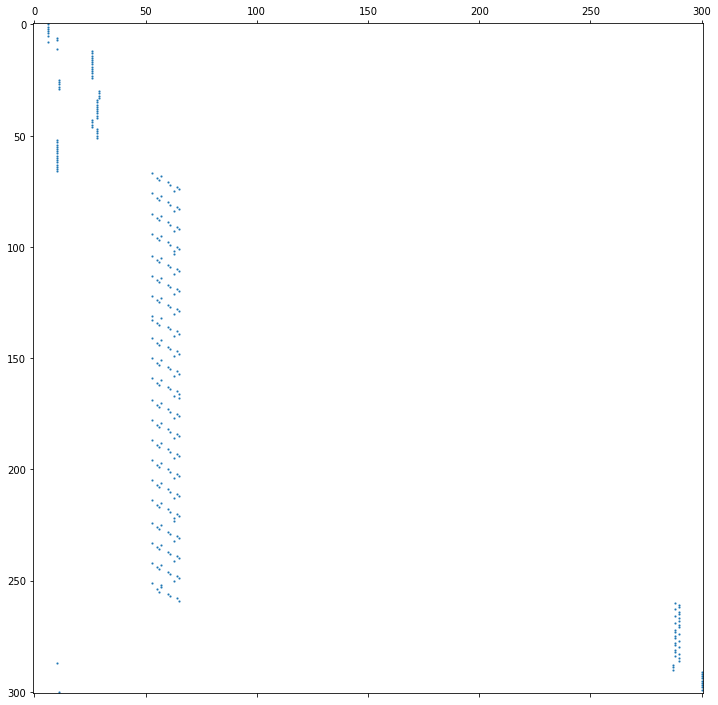

In [38]:
managers=data[['employee_name','manager_name']]
adj_matr=np.zeros(301*301).reshape(301,301)

indx = {'Brandon R. LeBlanc':6, 'Janet King':10,'Simon Roup':26,
        'Jennifer Zamora':11,'Eric Dougall':29,'Peter Monroe':28,'Michael Albert':53,
        'Elijiah Gray':57,'Webster Butler':55, 'Amy Dunn':56,'Ketsia Liebig':60,
        'Brannon Miller':61, 'David Stanley':64, 'Kissy Sullivan':65, 'Kelley Spirea':63,
        'Lynn Daneault':288, 'John Smith':290, 'Debra Houlihan':287, 'Alex Sweetwater':300}

print('\n')

for i in range(301):
    if managers.loc[i,'manager_name']!='Board of Directors':
        adj_matr[i,indx.get(managers.loc[i,'manager_name'])]=1
        #adj_matr[indx.get(managers.loc[i,'manager_name']),i]=1
plt.figure(figsize=(12,13))
fig=plt.spy(adj_matr, markersize=1)
plt.savefig('adj.png',dpi=1000)

In [42]:
G = nx.from_numpy_matrix(adj_matr)
pos_nodes = nx.spring_layout(G)

In [43]:
from colour import Color
red = Color('white')
colors = list(red.range_to(Color('green'),7))
color_dict = {key: value.hex for key, value in enumerate(colors)}
color_map = []
for node in G:
    color_map.append(color_dict.get(data.performance_score[node]))

In [44]:
nx.get_node_attributes(G,'perf').tolist()

AttributeError: 'dict' object has no attribute 'tolist'

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


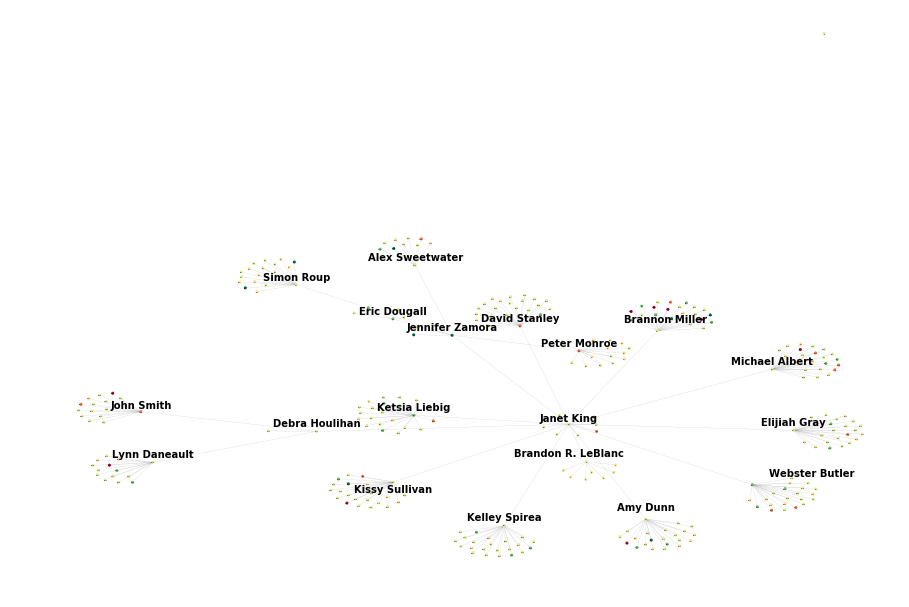

In [64]:

plt.figure(figsize=(12, 8))

color_dict={0:'green',1:'yellow',2:'red'}

color_map = []
for node in G:
    color_map.append(color_dict.get(classes[node]))
    
from colour import Color
red = Color('white')
colors = list(red.range_to(Color('green'),7))
color_dict = {key: value.hex for key, value in enumerate(colors)}
color_map = []
for node in G:
    color_map.append(color_dict.get(data.performance_score[node]))

nx.set_node_attributes(G, data.performance_score, 'perf')

nx.draw(G, pos_nodes,node_size=4,node_color=data.performance_score.replace(0,3),vmin=1,vmax=6,cmap = 'RdYlGn', with_labels=True,font_size=2,font_color='black',edge_color='grey',width=0.1)

pos_attrs = {}
for node, coords in pos_nodes.items():
    pos_attrs[node] = [coords[0], coords[1] + 0.02]

managers=[6,10,26,11,29,28,53,57,55,56,60,61,64,65,63,288,290,287,300]
pos = { manager: pos_nodes[manager] for manager in managers }    
lab = dict(map(reversed, indx.items()))


pos_attrs[61]=(pos_attrs[61]+np.array([0.01,0.01])).tolist()
pos_attrs[55]=(pos_attrs[55]+np.array([0.07,0.01])).tolist()
pos_attrs[56]=(pos_attrs[56]+np.array([0.0,0.01])).tolist()
pos_attrs[6]=(pos_attrs[6]+np.array([-0.02,0])).tolist()
pos_attrs[65]=(pos_attrs[65]+np.array([0,-0.04])).tolist()
pos_attrs[10]=(pos_attrs[10]+np.array([0,-0.005])).tolist()
pos_attrs[290]=(pos_attrs[290]+np.array([0,-0.005])).tolist()
#node_attrs = nx.get_node_attributes(G, 'type')
#custom_node_attrs = {}
#for node, attr in node_attrs.items():
#    custom_node_attrs[node] = "{'type': '" + attr + "'}"

nx.draw_networkx_labels(G, pos_attrs, labels=lab,font_size=10,font_weight='bold')
plt.savefig('graph1.png',dpi=1000)

In [46]:
(pos_attrs[61]+np.array([0,1])).tolist()

[0.16308006352049853, 1.2415354651352002]

In [47]:
print(pos_nodes[0])
print(pos_nodes.items())


[ 0.0416975  -0.15876557]
dict_items([(0, array([ 0.0416975 , -0.15876557])), (1, array([ 0.10142215, -0.16343431])), (2, array([ 0.06835613, -0.18259562])), (3, array([ 0.0506255 , -0.17551873])), (4, array([ 0.1036745 , -0.14383583])), (5, array([ 0.07523637, -0.16332784])), (6, array([ 0.0688343 , -0.13505432])), (7, array([ 0.03731883, -0.01169842])), (8, array([ 0.08888229, -0.17800898])), (9, array([0.34984037, 1.        ])), (10, array([ 0.04819911, -0.03560751])), (11, array([-0.08950517,  0.20004824])), (12, array([-0.31014706,  0.39825933])), (13, array([-0.30947836,  0.33322229])), (14, array([-0.31998468,  0.31553247])), (15, array([-0.29191711,  0.40151697])), (16, array([-0.32254583,  0.34236684])), (17, array([-0.33368195,  0.32576097])), (18, array([-0.32393678,  0.39015931])), (19, array([-0.27586213,  0.39435277])), (20, array([-0.29876613,  0.3882627 ])), (21, array([-0.28178573,  0.38040678])), (22, array([-0.32921447,  0.3767266 ])), (23, array([-0.31302089,  0.378

# 5. Investigate level of diversity in company

In [56]:
data.dtypes

employee_name                  object
employee_number               float64
state                          object
zip                           float64
dob                    datetime64[ns]
age                           float64
sex                            object
maritaldesc                    object
citizendesc                    object
hispanic_latino                object
racedesc                       object
date_of_hire           datetime64[ns]
date_of_termination    datetime64[ns]
reason_for_term                object
employment_status              object
department                     object
position                       object
pay_rate                      float64
manager_name                   object
employee_source                object
performance_score                int8
tenure                          int64
return                        float64
rel_pay                       float64
dtype: object

In [62]:
from collections import Counter
Counter(data["position"])

Counter({'Accountant I': 3,
         'Administrative Assistant': 3,
         'Shared Services Manager': 2,
         'Sr. Accountant': 2,
         'President & CEO': 1,
         'CIO': 1,
         'Database Administrator': 13,
         'IT Director': 1,
         'IT Manager - DB': 2,
         'IT Manager - Infra': 1,
         'IT Manager - Support': 1,
         'IT Support': 4,
         'Network Engineer': 9,
         'Sr. DBA': 4,
         'Sr. Network Engineer': 5,
         'Director of Operations': 1,
         'Production Manager': 14,
         'Production Technician I': 136,
         'Production Technician II': 57,
         'Area Sales Manager': 27,
         'Director of Sales': 1,
         'Sales Manager': 3,
         'Software Engineer': 9,
         'Software Engineering Manager': 1})

In [78]:
from collections import Counter
from scipy.stats import entropy

def normalized_entropy(values, num_classes=None):
    """Compute the normalized entropy for a collection of categorical values.
    
    The entropy is normalized with respect to the uniform distribution. The
    normalized entropy ranges from 0 (no dispersion) to 1 (maximum dispersion).
    """
    
    count = Counter(values)
    if num_classes is None:
        num_classes = len(count)
    
    ent = entropy(list(count.values()))
    return ent / np.log(num_classes)

## Diversity based on sex

We first measure the relative entropy of sex:

In [79]:
normalized_entropy(data["sex"])

0.9823401967007526

0.98 indicates a very high level of parity based on sex.

We analyze disparities in salary.

Text(0, 0.5, 'Count')

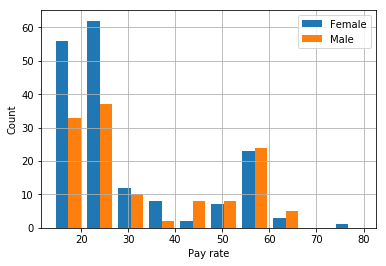

In [130]:
plt.hist([data[data["sex"] == "Female"]["pay_rate"], data[data["sex"] == "Male"]["pay_rate"]], 10,
         label=["Female", "Male"])
plt.legend()
plt.grid()
plt.xlabel("Pay rate")
plt.ylabel("Count")

In [133]:
# Average pay_rate
data[["sex", "pay_rate"]].groupby("sex").mean()

,pay_rate
sex,
Female,29.116782
Male,32.905276


In [135]:
# Standard deviation of pay_rate
data[["sex", "pay_rate"]].groupby("sex").std()

,pay_rate
sex,
Female,14.431078
Male,16.030218


There is a small but non-negligible difference between pay rates of men and women. We analyze now if those differences happen at a given position.

In [176]:
res = []
for p in set(data["position"]):
    position_data = data[data["position"] == p]
    num_employees = len(position_data)
    ent = normalized_entropy(position_data["sex"], num_classes=2)
    avg_salary = position_data[["sex", "pay_rate"]].groupby("sex").mean()
    avg_salary = avg_salary["pay_rate"].to_dict()
    res.append((p, num_employees, ent, avg_salary.get("Female", 0), avg_salary.get("Male", 0)))
#     print("'{}' relative entropy {:.2f} with {} employees".format(p, ent, num_employees))

res = pd.DataFrame(res, columns=["position", "num_employees", "entropy", "pay_rate_female", "pay_rate_male"])
res

,position,num_employees,entropy,pay_rate_female,pay_rate_male
0,Sales Manager,3,0.918296,57.125000,56.000000
1,IT Manager - Infra,1,0.000000,0.000000,63.000000
2,Production Manager,14,0.985228,47.500000,51.312500
3,Shared Services Manager,2,0.000000,0.000000,55.000000
4,IT Support,4,0.811278,28.296667,28.990000
5,Software Engineering Manager,1,0.000000,0.000000,27.000000
6,Sr. Network Engineer,5,0.970951,54.650000,54.333333
7,IT Manager - DB,2,0.000000,0.000000,41.500000
8,IT Manager - Support,1,0.000000,0.000000,64.000000
9,Software Engineer,9,0.918296,52.330000,48.556667


In general, all positions with a large number of employees have a relatively large entropy, indicating a good level of hiring parity. Regarding the pay_rate, there is a noticeable pay gap in favor of male Production Managers. A similar gap exists in favor of female Software Engineers. The company should review these cases?

## Diversity based on race

In [178]:
normalized_entropy(data["racedesc"])

0.6228770981924178

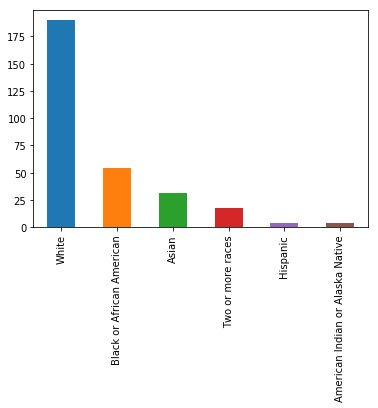

In [226]:
data["racedesc"].value_counts().plot(kind='bar')

The relative entropy is not very high. However, the distribution of races is not uniform in USA. For a proper comparison, we need to compare the distribution of races of hired employees with respect to the distribution of race demographics in the USA. From the 2010 US Census (https://www.census.gov/prod/cen2010/briefs/c2010br-02.pdf) we obtain the following demographics:

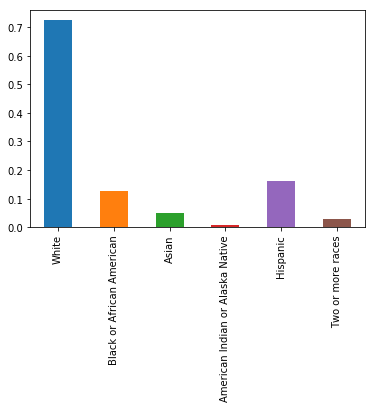

In [233]:
prior = {
    'White': 0.724,
    'Black or African American': 0.126,
    'Asian': 0.048,
    'American Indian or Alaska Native': 0.009,
#     'Native Hawaiians and Other Pacific Islanders': 0.002,
    # According to the US Census, 'Hispanic' is an 'ethnic origin', not a race, and being hispanic
    # is not incompatible with being also 'White' or 'Black'. Here we are assuming 'Hispanic' is an
    # independent race and, therefore, the following numerical results are not absolutely precise,
    # but they give an idea of the race-based parity level.
    'Hispanic': 0.163,
    'Two or more races': 0.029,
#     'Some other race': 0.062
}

s = pd.Series(list(prior.values()),index=prior.keys())
s.plot(kind='bar')

Both distributions have a similar visual appearance. We compute the wasserstein_distance (or the Earth mover's distance) between the distribution of hired races and the US demographics.

In [229]:
hired = Counter(data["racedesc"])
# hired.update({'Native Hawaiians and Other Pacific Islanders': 0, 'Some other race': 0})

racedescs = list(prior.keys())

prior = np.array([prior[k] for k in racedescs])
hired = np.array([hired[k] for k in racedescs])
prior = prior/prior.sum()
hired = hired/hired.sum()

In [230]:
from scipy.stats import wasserstein_distance

wasserstein_distance(hired, prior)

0.017436570243561808

The Wasserstein distance is 0.017. Small enough to claim that both distributions are reasonably similar. There is no apparent concern on the hiring process regarding races.

A position-wise analysis on race (as we did for sex) would not be meaningful given the relatively small amount of employees at each level and the relatively large number of races.